In [ ]:
!rm -rf ./ML4CV_XAI
!git clone https://github.com/liuktc/ML4CV_XAI.git
%load_ext autoreload

%autoreload 2

import sys
sys.path.append('/kaggle/working/ML4CV_XAI')

Simple script to fine-tune various models pretrained on ImageNet to the PascalVOC. 

In [2]:
%load_ext autoreload

%autoreload 2

import torch
from torch.utils.data import DataLoader
from models import vgg11_PascalVOC, resnet18_PascalVOC, vgg11_Syntetic, resnet18_Syntetic
from data import PascalVOC2007
from torchvision import transforms
import torchsummary


import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [4]:
# Train loop
import torch.optim as optim
import torch.nn as nn
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter

def train(model, dl_train, dl_val, device, epochs, lr = 0.0001):
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.Adam(model.parameters(), lr=0.0001)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=5e-2)
    early_stopping = EarlyStopping(patience=5, verbose=True)
    logger = SummaryWriter()

    train_history = {
        "accuracy": [],
        "loss": []
    }
    val_history = {
        "accuracy": [],
        "loss": []
    }
    for i in range(epochs):
        correct = 0
        total = 0
        
        for j, (images, labels) in tqdm(enumerate(dl_train), desc=f"Epoch {i+1}/{epochs}"):
            images = images.to(device)
            labels = labels.to(device).view(-1)
            
            optimizer.zero_grad()
            output = model(images)
                    
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            # for i, label in enumerate(labels):
            #     print(label)
            #     if label == 0:
            #         plt.imshow(images[i].permute(1, 2, 0))
            #         plt.show()
            #         break

            
            _, predicted = torch.max(output, 1)
            total += labels.size(0)
            
            train_history["loss"].append(loss.item())
            if j % 10 == 0:
                print(f"Loss: {loss.item()}")

            # log
            step = i * len(dl_train) + j
            logger.add_scalar('Loss/train', loss.item(), step)
            
        
        print(f"Loss: {loss.item()}")
        train_history["accuracy"].append(correct / total)
            
        # Calculate the metrics on the validation set
        correct = 0
        total = 0
        val_loss = []
        
        with torch.no_grad():
            for images, labels in tqdm(dl_val, leave=False, desc="Validation set"):
                images = images.to(device)
                labels = labels.to(device).view(-1)
                
                output = model(images)
                
                val_loss.append(criterion(output, labels))
                
                _, predicted = torch.max(output, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
        val_loss = torch.tensor(val_loss).mean().item()  
        
        val_history["accuracy"].append(correct / total)
        val_history["loss"].append(val_loss)
        
        print(f"Validation accuracy: {correct / total}")
        early_stopping(val_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping!")
            break

    return train_history, val_history

# VGG11

In [ ]:
vgg = vgg11_PascalVOC().to(device)

# Freeze all the model parameters
for param in vgg.parameters():
    param.requires_grad = False
 
# Unfreeze only the last layer
vgg.classifier[-1].requires_grad_(True)

# Print model summary
torchsummary.summary(vgg, (3, 224, 224))

In [ ]:
vgg_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),                 # Convert to Tensor
    transforms.Normalize(                  # Normalize using ImageNet mean and std
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

data_train_vgg = PascalVOC2007(image_set='train', transform=vgg_transform)
data_val_vgg = PascalVOC2007(image_set='val', transform=vgg_transform)

BATCH_SIZE = 64

dl_train_vgg = DataLoader(data_train_vgg, batch_size=BATCH_SIZE)
dl_val_vgg = DataLoader(data_val_vgg, batch_size=BATCH_SIZE)

In [ ]:
EPOCHS = 40
train_history_vgg, val_history_vgg = train(vgg, dl_train_vgg, dl_val_vgg, device, EPOCHS)

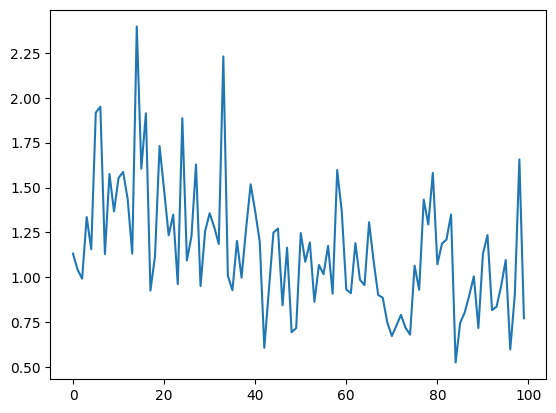

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.plot(train_history_vgg["loss"], label="Train loss")
plt.plot(val_history_vgg["loss"], label="Validation loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_history_vgg["accuracy"], label="Train accuracy")
plt.plot(val_history_vgg["accuracy"], label="Validation accuracy")
plt.legend()

In [ ]:
# Save the model
torch.save(vgg.state_dict(), "VGG11_PascalVOC.pth")

# ResNet18

In [7]:
resnet = resnet18_PascalVOC().to(device)

resnet.requires_grad_(False)
resnet.fc.requires_grad_(True)

c:\Users\Luca\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


Linear(in_features=512, out_features=20, bias=True)

In [12]:
from torchvision.models.resnet import ResNet18_Weights
resnet_transforms = ResNet18_Weights.DEFAULT.transforms()

data_train_resnet = PascalVOC2007(image_set='train', transform=resnet_transforms)
data_val_resnet = PascalVOC2007(image_set='val', transform=resnet_transforms)

Using downloaded and verified file: data\VOCtrainval_06-Nov-2007.tar
Extracting data\VOCtrainval_06-Nov-2007.tar to data
Using downloaded and verified file: data\VOCtrainval_06-Nov-2007.tar
Extracting data\VOCtrainval_06-Nov-2007.tar to data


In [11]:
BATCH_SIZE = 64

dl_train_resnet = DataLoader(data_train_resnet, batch_size=BATCH_SIZE)
dl_val_resnet = DataLoader(data_val_resnet, batch_size=BATCH_SIZE)

NameError: name 'data_train_resnet' is not defined

In [24]:
train_history_resnet, val_history_resnet= train(resnet, dl_train_resnet, dl_val_resnet, device, 40)

Epoch 1/40:   0%|          | 0/99 [00:00<?, ?it/s]

torch.Size([64, 20]) torch.Size([64])
2.398717164993286
torch.Size([64, 20]) torch.Size([64])
1.922579288482666
torch.Size([64, 20]) torch.Size([64])
2.0539989471435547
torch.Size([64, 20]) torch.Size([64])
2.214005708694458
torch.Size([64, 20]) torch.Size([64])
2.162309408187866
torch.Size([64, 20]) torch.Size([64])
2.0722944736480713
torch.Size([64, 20]) torch.Size([64])
1.9953787326812744
torch.Size([64, 20]) torch.Size([64])
2.4295074939727783
torch.Size([64, 20]) torch.Size([64])
2.135560989379883
torch.Size([64, 20]) torch.Size([64])
2.1580705642700195
torch.Size([64, 20]) torch.Size([64])
2.20755672454834
torch.Size([64, 20]) torch.Size([64])
1.8747471570968628
torch.Size([64, 20]) torch.Size([64])
2.004319667816162
torch.Size([64, 20]) torch.Size([64])
1.9967546463012695
torch.Size([64, 20]) torch.Size([64])
1.7726168632507324
torch.Size([64, 20]) torch.Size([64])
1.8862981796264648
torch.Size([64, 20]) torch.Size([64])
2.3614327907562256
torch.Size([64, 20]) torch.Size([64])
1

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.plot(train_history_resnet["loss"], label="Train loss")
plt.plot(val_history_resnet["loss"], label="Validation loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_history_resnet["accuracy"], label="Train accuracy")
plt.plot(val_history_resnet["accuracy"], label="Validation accuracy")
plt.legend()

In [ ]:
# Save the model
torch.save(resnet.state_dict(), "ResNet18_PascalVOC.pth")

# Finetune VGG11 on Syntetic Dataset

In [5]:
vgg = vgg11_Syntetic().to(device)

# Freeze all the model parameters
for param in vgg.parameters():
    param.requires_grad = True
 
# Unfreeze only the last layer
vgg.classifier[-1].requires_grad_(True)

Linear(in_features=4096, out_features=6, bias=True)

In [6]:
from data import SynteticFigures, BlurImagePerlinNoise, Binarize
from torchvision.transforms import InterpolationMode
from models import vgg_preprocess

TRAIN_SIZE = 4096
VAL_SIZE = 256
BATCH_SIZE = 64



background_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    BlurImagePerlinNoise(scale=50),
])

mask_preprocess = transforms.Compose([
        transforms.Resize((224, 224), interpolation=InterpolationMode.NEAREST),
        transforms.GaussianBlur(kernel_size=15),
        transforms.ToTensor(),  # Convert to Tensor
        Binarize(),
])

data_train = SynteticFigures(background_path="./data/Waldo",
                            num_images=TRAIN_SIZE,
                            split='train',
                            num_shapes_per_image=1,
                            image_transform=vgg_preprocess,
                            background_transform=background_transform,
                            mask_preprocess=mask_preprocess,
                            size_range=(80, 100))

data_val = SynteticFigures(background_path="./data/Waldo",
                            num_images=VAL_SIZE,
                            split='val',
                            num_shapes_per_image=1,
                            image_transform=vgg_preprocess,
                            background_transform=background_transform,
                            mask_preprocess=mask_preprocess,
                            size_range=(80, 100))


train_dl = DataLoader(data_train, BATCH_SIZE, shuffle=True)
val_dl = DataLoader(data_val, BATCH_SIZE, shuffle=False)

In [ ]:
EPOCHS = 40
train_history_vgg, val_history_vgg = train(vgg, train_dl, val_dl, device, EPOCHS, lr=1e-4)

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.plot(train_history_vgg["loss"], label="Train loss")
plt.plot(val_history_vgg["loss"], label="Validation loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_history_vgg["accuracy"], label="Train accuracy")
plt.plot(val_history_vgg["accuracy"], label="Validation accuracy")
plt.legend()

# Finetune ResNet on Syntetic Dataset

In [ ]:
resnet18 = resnet18_Syntetic().to(device)
resnet18.requires_grad_(False)
resnet18.fc.requires_grad_(True)

c:\Users\Luca\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


Linear(in_features=512, out_features=3, bias=True)

In [ ]:
from models import resnet_preprocess
from data import SynteticFigures
from torchvision.transforms import InterpolationMode

background_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
])

image_transform = resnet_preprocess

mask_preprocess = transforms.Compose([
        transforms.Resize((224, 224), interpolation=InterpolationMode.NEAREST),
        # transforms.GaussianBlur(5),
        transforms.ToTensor(),  # Convert to Tensor
])


TRAIN_SIZE = 5000
VAL_SIZE = 500

data_train_vgg = SynteticFigures(background_path="./data/Waldo",
                                 num_images=TRAIN_SIZE,
                                 split='train',
                                 image_transform=image_transform,
                                 background_transform=background_transform,
                                 mask_preprocess=mask_preprocess)

data_val_vgg = SynteticFigures(background_path="./data/Waldo",
                               num_images=VAL_SIZE,
                               split='val',
                               image_transform=image_transform,
                               background_transform=background_transform,
                               mask_preprocess=mask_preprocess)
                               


BATCH_SIZE = 8

dl_train = DataLoader(data_train_vgg, batch_size=BATCH_SIZE)
dl_val= DataLoader(data_val_vgg, batch_size=BATCH_SIZE)

In [14]:
EPOCHS = 40
train_history_resnet, val_history_resnet = train(resnet18, dl_train, dl_val, device, EPOCHS)

NameError: name 'resnet18' is not defined

# Finetune VGG11 on Imagenettewoof

In [ ]:
from data import imagenettewoof
from models import vgg11_Imagenettewoof, vgg_preprocess
from torch.utils.data import DataLoader

vgg = vgg11_Imagenettewoof().to(device)

BATCH_SIZE = 64

dataset_train = imagenettewoof(root=".", split='train',size="320px", download=True, transform=vgg_preprocess)
dataset_val = imagenettewoof(root=".", split='val',size="320px", download=True, transform=vgg_transform)

dl_train = DataLoader(dataset_train, batch_size=BATCH_SIZE)

data\imagewoof2-160


In [19]:
history = train(vgg, dl_train, dl_train, device, 40)

Epoch 1/40: 0it [00:00, ?it/s]

Loss: 2.967198610305786


KeyboardInterrupt: 